# 📊 View as a histogram

In [ ]:
#| default_exp repr_plt

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close

In [ ]:
# |export
# |hide

import math
from typing import Union, Any, Optional as O

import torch
from matplotlib import pyplot as plt, axes, figure, rc_context, rcParams
from IPython.core.pylabtools import print_figure

from lovely_numpy.utils.utils import cached_property
from lovely_numpy.repr_plt import fig_plot
from lovely_numpy import config as np_config

from lovely_tensors.repr_str import to_str, pretty_str
from lovely_tensors.utils.misc import to_numpy
from lovely_tensors.utils.config import get_config

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.
# Gives the ability to call both .plt and .plt(ax=ax).  

class PlotProxy(): 
    """Flexible `PIL.Image.Image` wrapper"""

    def __init__(self, x:torch.Tensor):
        self.x = x
        self.params = dict( center="zero",
                            max_s=10000,
                            plt0=True,
                            ax=None)

    def __call__(   self,
                    center  :O[str] =None,
                    max_s   :O[int] =None,
                    plt0    :Any    =None,
                    ax      :O[axes.Axes]=None):

        self.params.update( { k:v for
                    k,v in locals().items()
                    if k != "self" and v is not None } )
        
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        cfg = get_config()
        with np_config( fig_close=cfg.fig_close,
                        fig_show=cfg.fig_show,
                        plt_seed=cfg.plt_seed ):
            return fig_plot( to_numpy(self.x),
                            summary=to_str(self.x, color=False),
                            ddof=1,
                            **self.params)

    def _repr_png_(self):
        return print_figure(self.fig, fmt="png",
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})

    def _repr_svg_(self):
        # Metadata and context for a mode deterministic svg generation
        metadata={
            "Date": None,
            "Creator": "Matplotlib, https://matplotlib.org/",
        }
        with rc_context({"svg.hashsalt": "1"}):
            svg_repr = print_figure(self.fig, fmt="svg", metadata=metadata)
        return svg_repr


In [ ]:
# |export
def plot(   x       : torch.Tensor, # Tensor to explore
            center  :str    ="zero",    # Center plot on  `zero`, `mean`, or `range`
            max_s   :int    =10000,     # Draw up to this many samples. =0 to draw all
            plt0    :Any    =True,      # Take zero values into account
            ax      :O[axes.Axes]=None  # Optionally provide a matplotlib axes.
        ) -> PlotProxy:
    
    args = locals()
    del args["x"]

    return PlotProxy(x)(**args)


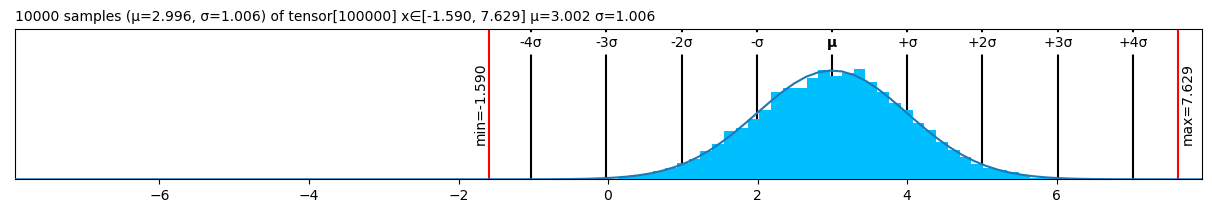

In [ ]:
torch.manual_seed(42)
t = torch.randn(100000)+3
plot(t)

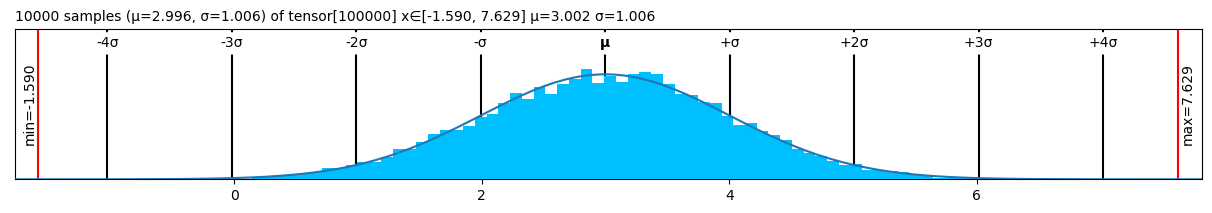

In [ ]:
plot(t, center="range")

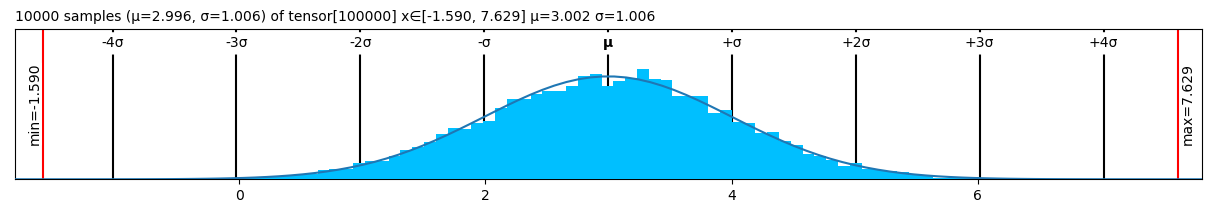

In [ ]:
plot(t, center="mean")

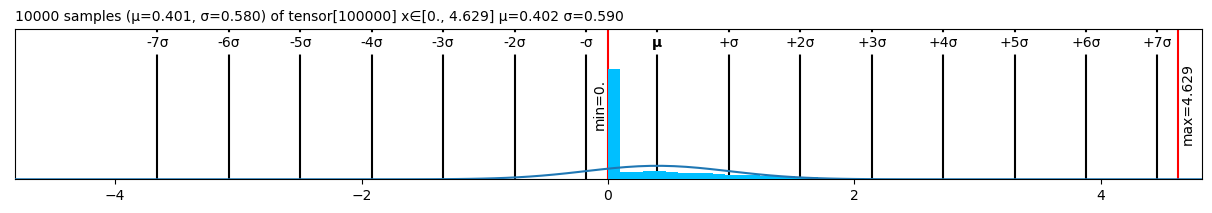

In [ ]:
plot(torch.nn.functional.relu(t-3))

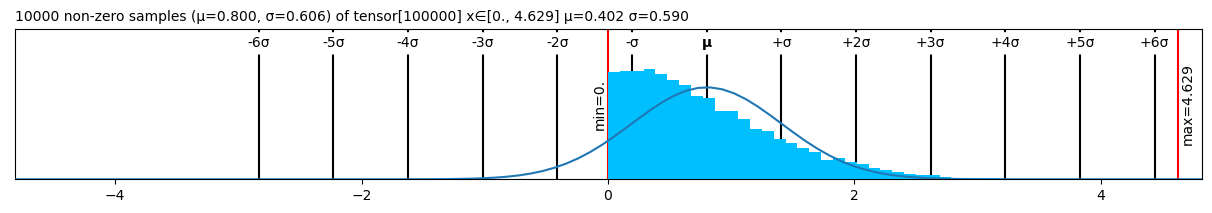

In [ ]:
plot(torch.nn.functional.relu(t-3), plt0=False)

In [ ]:
# |hide

# Deterministic svg output
rcParams["svg.hashsalt"] = "1"

# No date, don't include matplotlib version
kwargs = {'metadata': {"Date": None, "Creator": "Matplotlib, https://matplotlib.org/" }} 
%config InlineBackend.print_figure_kwargs = kwargs

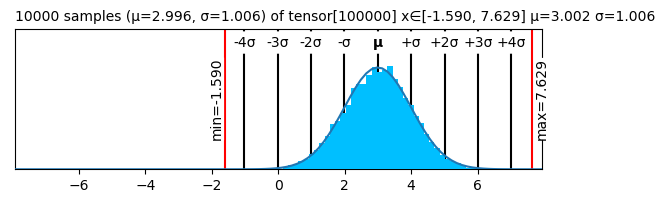

In [ ]:
fig, ax, = plt.subplots(figsize=(6, 2))
fig.tight_layout()
plot(t, ax=ax);

In [ ]:
# |hide
import gc

before allocation: 0
after allocation: 131072


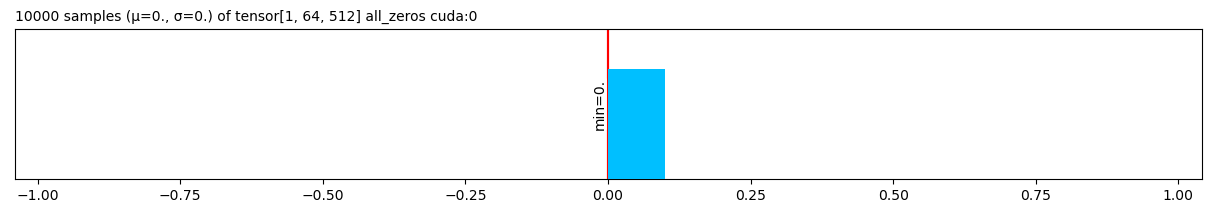

after rgb: 131072
after cleanup: 0


In [ ]:
# |hide
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()}")
    numbers = torch.zeros((1, 64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()}")
    display(plot(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()}")
   
    del numbers
    gc.collect()
    # torch.cuda.memory.empty_cache()
    # torch.cuda.synchronize()

    print(f"after cleanup: {torch.cuda.memory_allocated()}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)